In [1]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from tqdm.notebook import tqdm
import scipy.spatial.distance as spdists
import mpl_toolkits
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
#from curlyBrace import curlyB

ModuleNotFoundError: No module named 'mpl_toolkits.axes_grid'

In [ ]:
cm2in = 1/2.54
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'xtick.major.size': 4,
          'xtick.minor.size': 2,
          'ytick.major.size': 4,
          'ytick.minor.size': 2,
          'axes.linewidth'  : 0.75,
          'legend.fontsize'     : 10,
          'legend.handlelength' : 1.0,
          'legend.frameon'      : True,
          'legend.labelspacing' : 0.2,
          'legend.handletextpad':0.2,
          'legend.borderaxespad' : 0.2,
          'legend.framealpha'    : 1,
          'legend.facecolor'     : 'w',
          'figure.figsize': (13*cm2in, 10*cm2in),
          'axes.grid'           : True,
          'axes.axisbelow'      : True,
          'grid.linestyle'   :   '--',
          'grid.linewidth'   :   0.5
          }
plt.rcParams.update(params)

/home/rafal/WORK/IMPAN/Distributions/venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (i<len(simplices)) and (simplices[i][1]<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values


def get_ecc(data, n_samples, max_filt_val):
    eccs = []
    for dat in tqdm(data):
        ec = sampled_ecc_alpha(dat, n_samples, max_filt_val)
        eccs.append(ec)
    return eccs



def two_sample_ecc_test(X,Y, n_loops, steps, maxfilt):
    ecX = sampled_ecc_alpha(len(X)**(1/2)*X, steps,maxfilt)/len(X)
    ecY = sampled_ecc_alpha(len(Y)**(1/2)*Y, steps,maxfilt)/len(Y)
    D = np.max(np.abs(ecY - ecX))
    pool = np.concatenate((X,Y), axis = 0)
    pv = 0

    for p in tqdm(range(0,n_loops)):
        permuted_pool = np.random.permutation(pool)
        Xp = permuted_pool[:len(X)]
        Yp = permuted_pool[len(X):]

        ecXp = sampled_ecc_alpha(len(X)**(1/2)*Xp, steps,maxfilt)/len(X)
        ecYp = sampled_ecc_alpha(len(Y)**(1/2)*Yp, steps,maxfilt)/len(Y)
        dp = np.max(np.abs(ecXp - ecYp))
        if (dp>D):
            pv = pv + 1.0/n_loops

    return (pv)

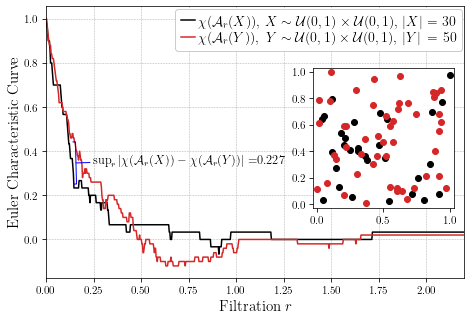

In [ ]:
np.random.seed(seed=15)
rv_uniform = st.uniform()
rv_beta = st.beta(3,3)
n_loops = 1000

n = 50
m = 30
d = 2
steps = 1001
maxfilt = 3

radii = np.linspace(0,maxfilt,steps)
X = np.array([rv_uniform.rvs(m), rv_uniform.rvs(m)]).T
Y = np.array([rv_uniform.rvs(n), rv_uniform.rvs(n)]).T

# f,ax1= plt.subplots(1,1, figsize = (5, 5))
# ax1.scatter(X[:,0], X[:,1], label ="$X$", color="black")
# ax1.scatter(Y[:,0], Y[:,1], label ="$Y$", color="tab:red")
# ax1.legend(loc='upper right')
# ax1.set_xlabel(r" ", fontsize=15)
# ax1.set_ylabel(r" ", fontsize=15)
# plt.savefig("2sample-H0-unif-vs-unif-square-n50.pdf", box_inches='tight')
#print(two_sample_ecc_test(X,Y, n_loops, steps, maxfilt))


ecX = sampled_ecc_alpha(len(X)**(1/2)*X, steps,maxfilt)/len(X)
ecY = sampled_ecc_alpha(len(Y)**(1/2)*Y, steps,maxfilt)/len(Y)
supdist = np.max(np.abs(ecX - ecY))
suparg = np.argmax(np.abs(ecX - ecY))

width = 7.5
height = 5
f,ax = plt.subplots(figsize = (width, height))
ax.plot(radii, ecX, label = "$\chi(\mathcal{A}_r(X))$, " + '$X \sim \mathcal{U}(0,1) \\times \mathcal{U}(0,1)$, $|X|$ = 30', color="black")
ax.plot(radii, ecY, label = "$\chi(\mathcal{A}_r(Y))$, " + '$\,Y \sim \mathcal{U}(0,1) \\times \mathcal{U}(0,1)$, $|Y|$\, = 50', color="tab:red")
#ax.plot(radii, ecX, label = "$\chi(\mathcal{A}_r(X))$", color="black")
#ax.plot(radii, ecY, label = "$\chi(\mathcal{A}_r(Y))$", color="tab:red")

# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax1, [0.65,0.29,0.5*height/width,0.5])
# ax2.set_axes_locator(ip)
# ax2.scatter(X[:,0], X[:,1], color="black")
# ax2.scatter(Y[:,0], Y[:,1], color="tab:red")
# ax2.set_xlim((-0.03,1.03))
# ax2.set_ylim((-0.03,1.03))
# ax2.grid(linewidth=0)

ax2 = f.add_axes([0.62,0.32,0.39*height/width,0.39])
ax2.scatter(X[:,0], X[:,1], color="black")
ax2.scatter(Y[:,0], Y[:,1], color="tab:red")
ax2.set_xlim((-0.03,1.03))
ax2.set_ylim((-0.03,1.03))
ax2.grid(linewidth=0)

arrow_center = (ecX[suparg] + ecY[suparg])/2
arrow_top = np.max([ecX[suparg], ecY[suparg]])
arrow_bottom = np.min([ecX[suparg], ecY[suparg]])
arrow_x = radii[suparg]

# ax.arrow(arrow_x, arrow_center, 0, arrow_top-arrow_center, head_width=0.025, color='blue', length_includes_head=True, zorder=20)
# ax.arrow(arrow_x, arrow_center, 0, arrow_bottom-arrow_center, head_width=0.025, color='blue', length_includes_head=True, zorder=20)
# ax.annotate("$\sup_r |\chi(\mathcal{A}_r(X)) - \chi(\mathcal{A}_r(Y))|$ =" + f'{supdist:.3f}', fontsize = 15, 
#              xy=(radii[suparg],0.5*(ecX[suparg]+ecY[suparg])),xycoords="data",
#              xytext = (radii[suparg]+0.1,0.5*(ecX[suparg]+ecY[suparg])),
#              textcoords="data",arrowprops={"arrowstyle":"-[, widthB={}".format(supdist/9.0), 
#                                            "connectionstyle":"arc3","shrinkA":1,"shrinkB":2, "color":"black"})
ax.annotate("$\sup_r |\chi(\mathcal{A}_r(X)) - \chi(\mathcal{A}_r(Y))|$ =" + f'{supdist:.3f}', fontsize = 12.5, 
             xy=(radii[suparg],arrow_center),xycoords="data",
             xytext = (radii[suparg]+0.1,arrow_center ),
             textcoords="data",arrowprops={"arrowstyle":"-[, widthB={}".format(supdist/9*67),  #*67 selected by trial and error
                                           "connectionstyle":"arc3","shrinkA":1,"shrinkB":2, "color":"blue"})
ax.legend(fontsize=14)
ax.set_xlabel('Filtration '+r'$r$', fontsize=15)
ax.set_ylabel('Euler Characteristic Curve', fontsize=15)
ax.set_xlim((0, 2.2))
plt.savefig("2sample-H0-ECC-unif-vs-unif-n50-supdist.svg", bbox_inches='tight')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

0


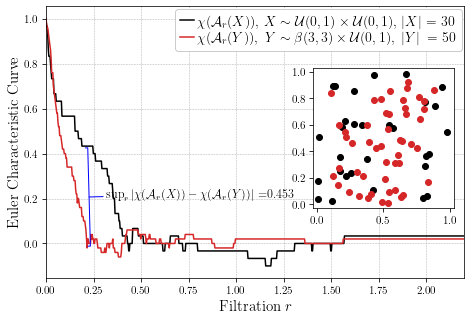

In [ ]:
np.random.seed(seed=100)
rv_uniform = st.uniform()
rv_beta = st.beta(3,3)
n_loops = 1000

n = 50
m = 30
d = 2
steps = 1001
maxfilt = 3

radii = np.linspace(0,maxfilt,steps)
X = np.array([rv_uniform.rvs(m), rv_uniform.rvs(m)]).T
Y = np.array([rv_beta.rvs(n), rv_uniform.rvs(n)]).T

# f,ax1= plt.subplots(1,1, figsize = (5, 5))
# ax1.scatter(X[:,0], X[:,1], label ="$X$", color="black")
# ax1.scatter(Y[:,0], Y[:,1], label ="$Y$", color="tab:red")
# ax1.legend(loc='upper right')
# ax1.set_xlabel(r" ", fontsize=15)
# ax1.set_ylabel(r" ", fontsize=15)
# plt.savefig("2sample-H1-unif-vs-beta-square-n50.pdf", box_inches='tight')
print(two_sample_ecc_test(X,Y, n_loops, steps, maxfilt))


ecX = sampled_ecc_alpha(len(X)**(1/2)*X, steps,maxfilt)/len(X)
ecY = sampled_ecc_alpha(len(Y)**(1/2)*Y, steps,maxfilt)/len(Y)
supdist = np.max(np.abs(ecX - ecY))
suparg = np.argmax(np.abs(ecX - ecY))

width = 7.5
height = 5
f,ax = plt.subplots(figsize = (width, height))
ax.plot(radii, ecX, label = "$\chi(\mathcal{A}_r(X))$, " + '$X \sim \mathcal{U}(0,1) \\times \mathcal{U}(0,1)$, $|X|$ = 30', color="black")
ax.plot(radii, ecY, label = "$\chi(\mathcal{A}_r(Y))$, " + '$\,Y \sim \\beta(3, 3) \\times \mathcal{U}(0,1)$,\, $|Y|$\, = 50', color="tab:red")

# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax1, [0.65,0.29,0.5*height/width,0.5])
# ax2.set_axes_locator(ip)
# ax2.scatter(X[:,0], X[:,1], color="black")
# ax2.scatter(Y[:,0], Y[:,1], color="tab:red")
# ax2.set_xlim((-0.03,1.03))
# ax2.set_ylim((-0.03,1.03))
# ax2.grid(linewidth=0)

ax2 = f.add_axes([0.62,0.32,0.39*height/width,0.39])
ax2.scatter(X[:,0], X[:,1], color="black")
ax2.scatter(Y[:,0], Y[:,1], color="tab:red")
ax2.set_xlim((-0.03,1.03))
ax2.set_ylim((-0.03,1.03))
ax2.grid(linewidth=0)


arrow_center = (ecX[suparg] + ecY[suparg])/2
arrow_top = np.max([ecX[suparg], ecY[suparg]])
arrow_bottom = np.min([ecX[suparg], ecY[suparg]])
arrow_x = radii[suparg]

#ax.arrow(arrow_x, arrow_center, 0, arrow_top-arrow_center, head_width=0.025, color='blue', length_includes_head=True, zorder=20)
#ax.arrow(arrow_x, arrow_center, 0, arrow_bottom-arrow_center, head_width=0.025, color='blue', length_includes_head=True, zorder=20)
ax.annotate("$\sup_r |\chi(\mathcal{A}_r(X)) - \chi(\mathcal{A}_r(Y))|$ =" + f'{supdist:.3f}', fontsize = 12.2, 
             xy=(radii[suparg],arrow_center),xycoords="data",
             xytext = (radii[suparg]+0.1,arrow_center ),
             textcoords="data",arrowprops={"arrowstyle":"-[, widthB={}".format(supdist/9*80),  #*67 selected by trial and error
                                           "connectionstyle":"arc3","shrinkA":1,"shrinkB":2, "color":"blue"})
ax.legend(fontsize=14)
ax.set_xlabel('Filtration '+r'$r$', fontsize=15)
ax.set_ylabel('Euler Characteristic Curve', fontsize=15)
plt.savefig("2sample-H1-ECC-unif-vs-unif-n50-supdist.svg", bbox_inches='tight')
ax.set_xlim((0, 2.2))
plt.show()

# Plots for 1sample

In [ ]:
np.random.seed(seed=100)
rv_uniform = st.uniform()
rv_beta = st.beta(3,3)

n=50
n_loops = 1000
d = 2
steps = 1001
maxfilt = 3

radii = np.linspace(0,maxfilt,steps)

sampleUxU = np.array([rv_uniform.rvs(n), rv_uniform.rvs(n)]).T
sampleBxB = np.array([rv_beta.rvs(n), rv_beta.rvs(n)]).T

ecUxU = sampled_ecc_alpha(n**(1/2)*sampleUxU, steps,maxfilt)
ecBxB = sampled_ecc_alpha(n**(1/2)*sampleBxB, steps,maxfilt)


# f, ax1= plt.subplots(1,1, figsize = (5,5))
# ax1.scatter(samplesUxU[:,0], samplesUxU[:,1], label =r"$X\sim \mathcal{U}(0, 1)\times\mathcal{U}(0, 1)$", color="black")
# ax1.scatter(samplesBxB[:,0], samplesBxB[:,1], label =r"$Y\sim \beta(3, 3)\times\beta(3, 3)$", color="tab:red")
# ax1.legend()
# plt.savefig("unif-vs-beta33-square-n50.pdf")
# plt.show()

radii = np.linspace(0,maxfilt,steps)
samplesUxU = [n**(1/2)*np.array([rv_uniform.rvs(n), rv_uniform.rvs(n)]).T for i in range(0,n_loops)]
eccs_UxU = get_ecc(samplesUxU, steps,maxfilt)
ecc_mean = np.mean(eccs_UxU, axis = 0)
supdistU = np.max(np.abs(ecc_mean - ecUxU))
suparg = np.argmax(np.abs(ecc_mean - ecUxU))

width = 8.5
height = 5
f, ax = plt.subplots(figsize = (width, height))
ax.plot(radii,ecc_mean, label = r"expected ECC for $\mathcal{U}(0, 1)\times\mathcal{U}(0, 1)$", color="tab:green", linewidth=2)
ax.plot(radii, ecUxU, label = r"$\chi(\mathcal{A}_r(X))$", color="black")

# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax, [0.72,0.24,0.45*height/width,0.45])
# ax2.set_axes_locator(ip)
# ax2.scatter(sampleUxU[:,0], sampleUxU[:,1], color="black")
# ax2.scatter(sampleBxB[:,0], sampleBxB[:,1], color="tab:red")
# ax2.set_xlim((-0.03,1.03))
# ax2.set_ylim((-0.03,1.03))
# ax2.grid(linewidth=0)

ax2 = f.add_axes([0.66,0.3,0.38*height/width,0.38])
ax2.scatter(sampleUxU[:,0], sampleUxU[:,1], color="black")
ax2.scatter(sampleBxB[:,0], sampleBxB[:,1], color="tab:red")
ax2.set_xlim((-0.03,1.03))
ax2.set_ylim((-0.03,1.03))
ax2.grid(linewidth=0)


supdist = np.max(np.abs(ecc_mean - ecUxU))
supdistU = supdist
suparg = np.argmax(np.abs(ecc_mean - ecUxU))

arrow_center = (ecc_mean[suparg] + ecUxU[suparg])/2
arrow_top = np.max([ecc_mean[suparg], ecUxU[suparg]])
arrow_bottom = np.min([ecc_mean[suparg], ecUxU[suparg]])
arrow_x = radii[suparg]
#ax.arrow(arrow_x, arrow_center, 0, arrow_top-arrow_center, head_width=0.025, color='blue', length_includes_head=True, zorder=20)
#ax.arrow(arrow_x, arrow_center, 0, arrow_bottom-arrow_center, head_width=0.025, color='blue', length_includes_head=True, zorder=20)
ax.annotate("$\sup_r |\chi(\mathcal{A}_r(X)) - E\chi(\mathcal{A}_r(X))|$ =" + f'{supdist:.3f} \n $\\Delta_n$ = {supdist/np.sqrt(n):.3f}', fontsize = 14, 
             xy=(radii[suparg],arrow_center),xycoords="data",
             xytext = (radii[suparg]+0.05,arrow_center),
             textcoords="data",arrowprops={"arrowstyle":"-[, widthB={}".format(supdist/9.0*1.5), 
                                           "connectionstyle":"arc3","shrinkA":1,"shrinkB":2, "color":"blue"})


ax.plot(radii, ecBxB, label = r"$\chi(\mathcal{A}_r(Y))$", color="tab:red")
supdist = np.max(np.abs(ecc_mean - ecBxB))
supdistB = supdist
suparg = np.argmax(np.abs(ecc_mean - ecBxB))
arrow_center = (ecc_mean[suparg] + ecBxB[suparg])/2
arrow_top = np.max([ecc_mean[suparg], ecBxB[suparg]])
arrow_bottom = np.min([ecc_mean[suparg], ecBxB[suparg]])
arrow_x = radii[suparg]
#ax.arrow(arrow_x, arrow_center, 0, arrow_top-arrow_center, head_width=0.025, color='blue', length_includes_head=True, zorder=20)
#ax.arrow(arrow_x, arrow_center, 0, arrow_bottom-arrow_center, head_width=0.025, color='blue', length_includes_head=True, zorder=20)
ax.annotate("$\sup_r |\chi(\mathcal{A}_r(Y)) - E\chi(\mathcal{A}_r(X))|$ =" + f'{supdist:.3f} \n$\\Delta_n$ = {supdist/np.sqrt(n):.3f}', fontsize = 14, 
             xy=(radii[suparg],arrow_center),xycoords="data",
             xytext = (radii[suparg]+0.1,arrow_center),
             textcoords="data",arrowprops={"arrowstyle":"-[, widthB={}".format(supdist/9.0*1.2), 
                                           "connectionstyle":"arc3","shrinkA":1,"shrinkB":2, "color":"blue"})
ax.legend(fontsize=14)
ax.set_xlabel('Filtration '+r'$r$', fontsize=15)
ax.set_ylabel('Euler Characteristic Curve', fontsize=15)
ax.set_xlim((0, 2.5))
plt.savefig("ECC-unif-vs-beta33-n50-supdist.svg", bbox_inches='tight',transparent=False, facecolor='white')
# savefit to pdf format is not working properly
# change the svg to pdf with rsvg-convert
#plt.show()
plt.close()

#compute pvals
samplesUxU = [n**(1/2)*np.array([rv_uniform.rvs(n), rv_uniform.rvs(n)]).T for i in range(0,n_loops)]
eccs_UxU = get_ecc(samplesUxU, steps,maxfilt)
Deltas = np.array([np.max(np.abs(ecc_mean-eccs_UxU[i])) for i in range(0,len(samplesUxU))])
print("PV uniform", np.mean(Deltas > supdistU))
print("PV beta", np.mean(Deltas > supdistB))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

PV uniform 0.916
PV beta 0.0


In [ ]:
np.quantile(Deltas/np.sqrt(n), 0.95)

1.3179268319789224

In [ ]:
supdistU

4.32

In [ ]:
supdistB

16.029